## implementing transreid 

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image


In [2]:
# ----- CONFIG -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("model/best.pt")  # Your fine-tuned YOLOv8 pose/detector
transreid_weights_path = "transreid.pth"  # Replace with path to TransReID weights
video_path = "dataset/tacticam.mp4"
output_dir = "saved_transreid_embeddings_tacticam"
max_frames = 5

# ----- Load TransReID model using TorchReID -----
from torchreid import models

transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()

# ----- Transform for TransReID -----
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Setup -----
cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# ----- Main Processing Loop -----
while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()

    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)

            # ----- TransReID Embedding -----
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1)  # Optional: normalized embedding

            # Save embedding
            emb_np = emb.detach().cpu().numpy()
            emb_path = os.path.join(frame_dir, f"player_{i}_embedding.npy")
            np.save(emb_path, emb_np)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (0, 255, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] Processed and saved.")
    frame_count += 1

cap.release()

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
[Frame 0] Processed and saved.
[Frame 1] Processed and saved.
[Frame 2] Processed and saved.
[Frame 3] Processed and saved.
[Frame 4] Processed and saved.


In [3]:
# ----- CONFIG -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("model/best.pt")  # Your fine-tuned YOLOv8 pose/detector
transreid_weights_path = "transreid.pth"  # Replace with path to TransReID weights
video_path = "dataset/broadcast.mp4"
output_dir = "saved_transreid_embeddings_broadcast"
max_frames = 5

# ----- Load TransReID model using TorchReID -----
from torchreid import models

transreid = models.build_model(
    name='osnet_ain_x1_0',
    num_classes=1000,
    pretrained=True
).to(device)
transreid.eval()

# ----- Transform for TransReID -----
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ----- Setup -----
cap = cv2.VideoCapture(video_path)
os.makedirs(output_dir, exist_ok=True)
frame_count = 0
font = cv2.FONT_HERSHEY_SIMPLEX

# ----- Main Processing Loop -----
while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    result = model.predict(source=frame, conf=0.75, save=False, verbose=False)[0]
    annotated = frame.copy()

    frame_dir = os.path.join(output_dir, f"frame_{frame_count}")
    os.makedirs(frame_dir, exist_ok=True)

    boxes = result.boxes
    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cls_id = int(box.cls[0].item())
            class_name = model.names[cls_id]

            if class_name.lower() != "player":
                continue

            crop = frame[y1:y2, x1:x2]
            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            input_tensor = transform(crop_pil).unsqueeze(0).to(device)

            # ----- TransReID Embedding -----
            emb = transreid(input_tensor)
            emb = F.normalize(emb, p=2, dim=1)  # Optional: normalized embedding

            # Save embedding
            emb_np = emb.detach().cpu().numpy()
            emb_path = os.path.join(frame_dir, f"player_{i}_embedding.npy")
            np.save(emb_path, emb_np)

            # Save crop
            crop_path = os.path.join(frame_dir, f"player_{i}.jpg")
            cv2.imwrite(crop_path, crop)

            # Annotate
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated, f"Player {i}", (x1, y1 - 10), font, 0.6, (0, 255, 0), 2)

    # Save annotated frame
    frame_path = os.path.join(frame_dir, "annotated.jpg")
    cv2.imwrite(frame_path, annotated)

    print(f"[Frame {frame_count}] Processed and saved.")
    frame_count += 1

cap.release()

Successfully loaded imagenet pretrained weights from "/Users/vivek/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
[Frame 0] Processed and saved.
[Frame 1] Processed and saved.
[Frame 2] Processed and saved.
[Frame 3] Processed and saved.
[Frame 4] Processed and saved.


In [7]:
import os
import numpy as np
import torch
import torch.nn.functional as F

# ----------- Set your input directories here -----------
frame_dir_1 = "saved_transreid_embeddings_tacticam/frame_0"
frame_dir_2 = "saved_transreid_embeddings_broadcast/frame_0"
# --------------------------------------------------------

def load_embeddings_from_dir(frame_dir):
    embeddings = []
    names = []

    for file in os.listdir(frame_dir):
        if file.endswith("_embedding.npy"):
            path = os.path.join(frame_dir, file)
            emb = np.load(path)
            emb = torch.from_numpy(emb).float()
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb)
            names.append(file.replace("_embedding.npy", ""))
    return embeddings, names

# Load all embeddings
emb_list_1, names_1 = load_embeddings_from_dir(frame_dir_1)
emb_list_2, names_2 = load_embeddings_from_dir(frame_dir_2)

# Compute pairwise cosine similarities
print(f"\n🔍 Similarity Matrix (Players in Frame 1 vs Frame 2):\n")
for i, (emb1, name1) in enumerate(zip(emb_list_1, names_1)):
    row = []
    for j, (emb2, name2) in enumerate(zip(emb_list_2, names_2)):
        sim = torch.mm(emb1, emb2.t()).item()
        row.append(f"{sim:.3f}")
    print(f"{name1:20}: {'  '.join(row)}")


🔍 Similarity Matrix (Players in Frame 1 vs Frame 2):

player_4            : 0.575  0.684  0.590  0.699  0.608  0.574  0.599  0.645  0.683  0.629  0.500
player_0            : 0.531  0.734  0.641  0.593  0.608  0.604  0.513  0.649  0.541  0.611  0.521
player_21           : 0.626  0.601  0.580  0.590  0.663  0.631  0.666  0.701  0.513  0.563  0.538
player_18           : 0.542  0.673  0.638  0.646  0.661  0.594  0.578  0.683  0.579  0.603  0.492
player_7            : 0.583  0.588  0.555  0.539  0.683  0.633  0.631  0.752  0.512  0.500  0.494
player_3            : 0.575  0.612  0.627  0.537  0.649  0.635  0.590  0.688  0.451  0.578  0.476
player_9            : 0.594  0.659  0.628  0.579  0.682  0.600  0.585  0.704  0.514  0.618  0.507
player_12           : 0.605  0.581  0.513  0.561  0.630  0.634  0.606  0.731  0.491  0.511  0.455
player_16           : 0.580  0.584  0.603  0.541  0.704  0.626  0.642  0.709  0.492  0.579  0.578
player_11           : 0.468  0.593  0.579  0.530  0.601  0.513 

## plot confustion matrix

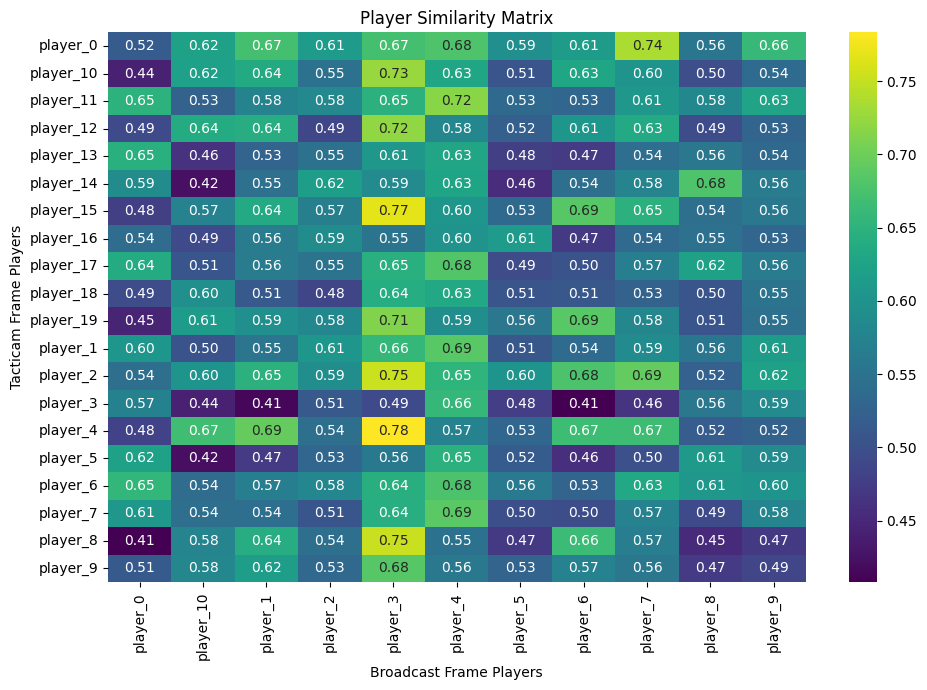

In [10]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Set your input directories here -----------
frame_dir_1 = "saved_transreid_embeddings_tacticam/frame_4"
frame_dir_2 = "saved_transreid_embeddings_broadcast/frame_4"
# --------------------------------------------------------

def load_embeddings_from_dir(frame_dir):
    embeddings = []
    names = []

    for file in sorted(os.listdir(frame_dir)):
        if file.endswith("_embedding.npy"):
            path = os.path.join(frame_dir, file)
            emb = np.load(path)
            emb = torch.from_numpy(emb).float()
            emb = F.normalize(emb, p=2, dim=1)
            embeddings.append(emb)
            names.append(file.replace("_embedding.npy", ""))
    return embeddings, names

# Load embeddings
emb_list_1, names_1 = load_embeddings_from_dir(frame_dir_1)
emb_list_2, names_2 = load_embeddings_from_dir(frame_dir_2)

# Compute similarity matrix
similarity_matrix = np.zeros((len(emb_list_1), len(emb_list_2)))

for i, emb1 in enumerate(emb_list_1):
    for j, emb2 in enumerate(emb_list_2):
        sim = torch.mm(emb1, emb2.t()).item()
        similarity_matrix[i, j] = sim

# ---- Plot using seaborn ----
plt.figure(figsize=(10, 7))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=names_2, yticklabels=names_1)
plt.xlabel("Broadcast Frame Players")
plt.ylabel("Tacticam Frame Players")
plt.title("Player Similarity Matrix")
plt.tight_layout()
plt.show()